In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
sns.set(rc = {'figure.figsize':(13,8)})

In [6]:
df = pd.read_csv("VENUS_current_data.csv")
df.describe()

,trial index,file index,block index,beam_avg,beam_std,inj_avg,inj_std,ext_avg,ext_std,mid_avg,mid_std,bias_avg,bias_std,inj_p_avg,inj_p_std,ext_p_avg,ext_p_std
count,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02
mean,0.529697,12.232727,15.675152,120.433940,4.259700,124.098079,0.006897,102.950431,0.004544,101.414511,0.003325,4.207574,0.090337,1.130783e-07,3.792456e-10,7.247788e-09,1.124259e-10
std,0.499420,5.562238,9.464224,32.696779,5.463373,3.291434,0.005427,3.693689,0.002837,3.451216,0.001832,0.776497,0.091811,5.672049e-09,2.300330e-10,3.498779e-09,9.675340e-10
min,0.000000,0.000000,0.000000,23.862232,0.378532,117.005536,0.000000,96.990714,0.000000,94.999643,0.000000,2.337157,0.012404,9.999310e-08,0.000000e+00,5.089286e-09,1.477867e-11
25%,0.000000,9.000000,8.000000,100.484776,1.480076,121.588571,0.004417,100.306379,0.002915,98.901964,0.001873,3.678373,0.032498,1.090000e-07,2.272078e-10,6.085000e-09,3.100848e-11
50%,1.000000,13.000000,16.000000,124.899224,2.379627,124.328448,0.005391,102.743571,0.004509,101.280000,0.003531,4.142009,0.054265,1.123214e-07,3.954521e-10,6.660357e-09,4.446507e-11
75%,1.000000,16.000000,24.000000,144.493879,4.360233,126.707931,0.007559,105.547857,0.005366,103.780357,0.004734,4.688318,0.112466,1.169828e-07,4.934538e-10,7.645345e-09,5.148666e-11
max,1.000000,22.000000,34.000000,179.487321,34.172754,130.011071,0.056671,110.003214,0.037604,110.000179,0.010710,7.039993,0.906392,1.314655e-07,1.859639e-09,9.509107e-08,2.391238e-08


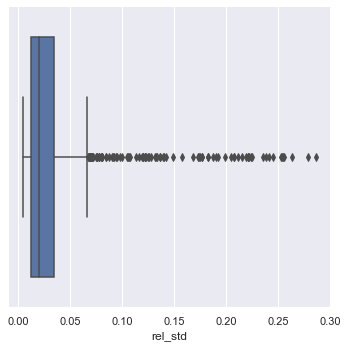

In [7]:
df["rel_std"] = df["beam_std"] / df["beam_avg"]
sns.catplot(x="rel_std", kind="box", data=df)
# TODO: Do normalization more carefully

Text(0.5, 1.0, 'Cost Function')

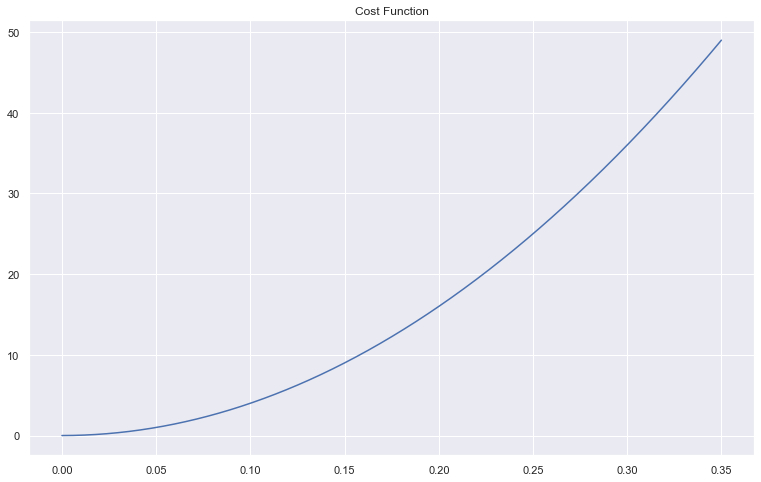

In [14]:
x = np.linspace(0,0.35,1000)
magnitude = 100
steepness = 50
sigmoid = lambda x: magnitude * 1/(1+math.e**(-steepness*(x-0.10)))

squared = lambda x: (20*x)**2


costfunction = squared
plt.plot(x, costfunction(x))
plt.title("Cost Function")

# TODO: try square / other cost functions
# TODO: more evaluation! close the circle
# TODO: optimize more parameters
# TODO: write a five page report
# motivation, methods, results

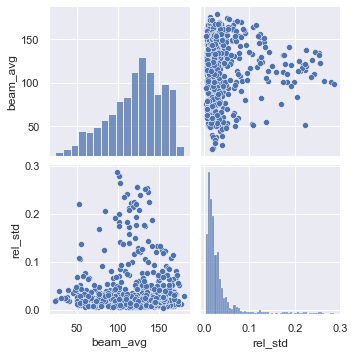

In [15]:
beam_current = df[["beam_avg", "rel_std"]]
sns.set(rc = {'figure.figsize':(15,8)})
sns.pairplot(beam_current)

### Observation 1:
we see not strong indication of whether beam current is stable from the magnetude of beam current itself.

So what is it related to?

<AxesSubplot:>

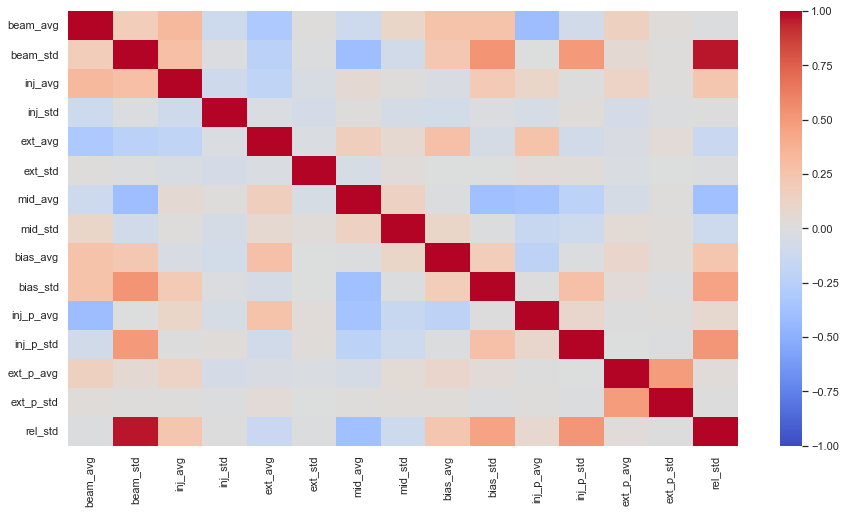

In [16]:
corr = df.drop(["trial index", "file index", "block index"], axis=1).corr()
sns.heatmap(corr, cmap = 'coolwarm',vmin=-1, vmax=1)
#corr

#TODO: colormap
# [df["trial index"]==1]

### Observation 2:
high mid_current seem to make the beam_current more stable. bias_std and inj_std are pretty correlated with instable beam current. 

# Generating a "Mixed Goal"

In [23]:
exp_num = 3
withStability = True

def generate_goal(exp_num:int, withStability:bool, costfunction):
    data = df.loc[df['trial index'] == exp_num-1][["beam_avg", "beam_std", "inj_avg", "ext_avg", "mid_avg", "rel_std"]]
    
    beam_avg_arr = np.array(data["beam_avg"].to_list())
    # Note: using rel_std instead of beam_std here
    beam_std_arr = np.array(data["rel_std"].to_list())
    goal = beam_avg_arr - costfunction(beam_std_arr) if withStability else beam_avg_arr

    xpts = data["mid_avg"].to_list()
    ypts = data["ext_avg"].to_list()
    zpts = data["inj_avg"].to_list()
    
    xpts, ypts, zpts, sizepts, magpts = xpts, ypts, zpts, [], list(goal)

    # Data saving sniphet from "Venus Data Exploration/Analyze Runs"
    data_list = [xpts, ypts, zpts, sizepts, magpts]
    target_file = "data%d(withStability).pkl"%exp_num if withStability else "data%d.pkl"%exp_num
    open_file = open(target_file, "wb")
    pickle.dump(data_list, open_file)
    open_file.close()

generate_goal(exp_num, withStability, costfunction)
    

In [24]:
# regenerate all data
for exp_num in range(1,4):
    for withStability in [True, False]:
        generate_goal(exp_num, withStability, costfunction)


# results of GPR on the mixed goal data
## Exp1 
### without adding stability: 
Train score: 0.968700
Test score:  0.800158 
### with stability: 
Train score: 0.969914
Test score:  0.715967 

## Exp2
### without adding stability: 
Train score: 0.955145
Test score:  0.660376 
### with stability: 
Train score: 0.945324
Test score:  0.620582 
